In [57]:
import pickle
import json
import os
import re
import sys
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import skimage
import tifffile
import yaml
from matplotlib.collections import PolyCollection
from matplotlib.colors import TwoSlopeNorm
from einops import rearrange, repeat
from pydantic_extra_types.color import Color

In [7]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'

In [8]:
%load_ext autoreload

In [9]:
%autoreload 2

In [10]:
from mushroom.mushroom import Mushroom, DEFAULT_CONFIG
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils
import mushroom.data.multiplex as multiplex
import mushroom.data.visium as visium
import mushroom.data.xenium as xenium
import mushroom.data.cosmx as cosmx
import mushroom.visualization.tiling_utils as tiling_utils

In [11]:
source_root = '/diskmnt/Projects/Users/estorrs/mushroom/data'
target_root = '/data/estorrs/mushroom/data'

In [12]:
run_dir = '/data/estorrs/mushroom/data/projects/submission_v1'

In [13]:
def alter_filesystem(config, source_root, target_root):
    for entry in config['sections']:
        for mapping in entry['data']:
            mapping['filepath'] = mapping['filepath'].replace(source_root, target_root)
        
    return config

In [14]:
disease_to_cases = {
    'brca': ['HT704B1', 'HT206B1', 'HT397B1'],
    'prad': ['HT891Z1', 'HT913Z1']
}

In [15]:
case_to_dir = {
    k:Path(f'/data/estorrs/mushroom/data/projects/submission_v1/{k}') for d in disease_to_cases.values() for k in d
}
case_to_config = {
    k:alter_filesystem(
        yaml.safe_load(open(os.path.join(v, 'registered', 'metadata.yaml'))), source_root, target_root)
    for k, v in case_to_dir.items()
}

In [43]:
def get_roi_to_data(result_dir, region_dir):
    result_dir = case_to_dir[case] / 'imaris' / 'rois' / 'results'
    fps = sorted(utils.listfiles(result_dir))

    roi_to_results = {}
    for fp in fps:
        name = fp.split('/')[-1].split('.')[0]
        roi = re.sub(r'^(roi[0-9]+).*$', r'\1', name)
        dti = re.sub(r'^roi[0-9]+_(.*)_.*$', r'\1', name)
        file_type = re.sub(r'^roi[0-9]+_.*_(.*)$', r'\1', name)
    
        if roi not in roi_to_results:
            roi_to_results[roi] = {}
        if dti not in roi_to_results[roi]:
            roi_to_results[roi][dti] = {}
    
        if file_type == 'metadata':
            roi_to_results[roi][dti][file_type] = json.load(open(fp))
        else:
            roi_to_results[roi][dti][file_type] = pd.read_csv(fp, sep='\t', index_col=0)

    
    roi_to_data = {}
    for roi, results in roi_to_results.items():
        fp = region_dir / f'{roi}_metadata.json'
        data = json.load(open(fp))
        data['results'] = results
        roi_to_data[roi] = data
    

    return roi_to_data

In [376]:
sns.color_palette('deep')

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [377]:
dti_to_color = {
    'xenium_0': sns.color_palette('deep')[0],
    'xenium_1': sns.color_palette('deep')[0],
    'codex_0': sns.color_palette('deep')[2],
    'cosmx_0': sns.color_palette('deep')[5],
    'vishd_0': sns.color_palette('deep')[8],
}

## case-specific combined

In [44]:
case = 'HT704B1'
result_dir = case_to_dir[case] / 'imaris' / 'rois' / 'results'
region_dir = case_to_dir[case] / 'imaris' / 'rois' / 'regions'
roi_to_data = get_roi_to_data(result_dir, region_dir)

In [380]:
fig_dir = case_to_dir[case] / 'imaris' / 'rois' / 'integrated_analysis'
fig_dir.mkdir(parents=True, exist_ok=True)

In [45]:
pathology_order = next(iter(roi_to_data.values()))['pathology_order']
pathology_order

['Normal', 'DCIS', 'IDC - partial', 'IDC']

In [371]:
pathology_to_color = next(iter(roi_to_data.values()))['case_to_pathology_colors'][case]
pathology_to_color

{'IDC': [150, 29, 138],
 'IDC - partial': [171, 20, 12],
 'DCIS': [191, 128, 11],
 'Normal': [36, 117, 15]}

In [352]:
inclusion_genes = {}

def get_visiumhd_included(a, n):
    sparsity = np.asarray((a.X>=1).sum(0)).flatten()
    a = a[:, sparsity > n]

    a = a[:, [True if 'MT-' not in x else False for x in a.var.index.to_list()]]
    
    genes = a.var.index.to_list()
    
    return genes

n = 1000
if case == 'HT704B1':
    a = sc.read_h5ad('/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/HT704B1-U2_visiumhd.h5ad')
    genes = get_visiumhd_included(a, n)
    inclusion_genes['vishd_0'] = genes
elif case == 'HT891Z1':
    a = sc.read_h5ad('/data/estorrs/mushroom/data/projects/submission_v1/HT891Z1/registered/HT891Z1-U2_visiumhd.h5ad')
    genes = get_visiumhd_included(a, n)
    inclusion_genes['vishd_0'] = genes


/data/estorrs/miniconda3/envs/mushroom_v2/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


###### cross dtype degs

In [353]:
datas = []
for roi, data in roi_to_data.items():
    for dti, result in data['results'].items():
        df = result['expression']
        df['id'] = df.index.to_list()
        melted = df.melt(id_vars='id')
        for rid, gene, val in zip(melted['id'], melted['variable'], melted['value']):
            if isinstance(val, float):
                datas.append([roi, dti, rid, data['region_id_to_pathology'][rid], gene, val])
df = pd.DataFrame(data=datas, columns=['roi', 'dtype_ident', 'region_id', 'annotation', 'gene', 'value'])
df
        

,roi,dtype_ident,region_id,annotation,gene,value
0,roi1,cosmx_0,25f59172-9dc6-4340-a21f-2a2b557176cf,DCIS,AATK,1.260581
1,roi1,cosmx_0,a4719551-76dd-4117-a82a-c086568f52f2,IDC,AATK,1.742139
2,roi1,cosmx_0,7ee62508-a502-404f-b93c-47d0fa181aab,IDC,AATK,1.425868
3,roi1,cosmx_0,25f59172-9dc6-4340-a21f-2a2b557176cf,DCIS,ABL1,1.482688
4,roi1,cosmx_0,a4719551-76dd-4117-a82a-c086568f52f2,IDC,ABL1,1.617586
...,...,...,...,...,...,...
141641,roi3,xenium_0,acb0503f-4a7b-46c2-b261-0eb852d1bd8d,DCIS,VWF,0.074309
141642,roi3,xenium_0,a1dc0f9b-9074-472c-ae87-4d84e7c02a23,DCIS,VWF,0.097420
141643,roi3,xenium_0,7ebbea05-4f2c-40fd-af67-b519caecdf1a,DCIS,VWF,0.155320
141644,roi3,xenium_0,2769f76d-7eb7-423e-b85d-48d97e1cc0e2,DCIS,VWF,0.162761


In [354]:
for dti, included in inclusion_genes.items():
    pool = set(included)
    m = np.asarray([False if dt == dti and gene not in pool else True for dt, gene in zip(df['dtype_ident'], df['gene'])]) 
    df = df[m]
df

,roi,dtype_ident,region_id,annotation,gene,value
0,roi1,cosmx_0,25f59172-9dc6-4340-a21f-2a2b557176cf,DCIS,AATK,1.260581
1,roi1,cosmx_0,a4719551-76dd-4117-a82a-c086568f52f2,IDC,AATK,1.742139
2,roi1,cosmx_0,7ee62508-a502-404f-b93c-47d0fa181aab,IDC,AATK,1.425868
3,roi1,cosmx_0,25f59172-9dc6-4340-a21f-2a2b557176cf,DCIS,ABL1,1.482688
4,roi1,cosmx_0,a4719551-76dd-4117-a82a-c086568f52f2,IDC,ABL1,1.617586
...,...,...,...,...,...,...
141641,roi3,xenium_0,acb0503f-4a7b-46c2-b261-0eb852d1bd8d,DCIS,VWF,0.074309
141642,roi3,xenium_0,a1dc0f9b-9074-472c-ae87-4d84e7c02a23,DCIS,VWF,0.097420
141643,roi3,xenium_0,7ebbea05-4f2c-40fd-af67-b519caecdf1a,DCIS,VWF,0.155320
141644,roi3,xenium_0,2769f76d-7eb7-423e-b85d-48d97e1cc0e2,DCIS,VWF,0.162761


In [355]:
roi_order = sorted(set(df['roi']))
dti_order = sorted(set(df['dtype_ident']))

In [356]:
maxs = df[['dtype_ident', 'gene', 'value']].groupby(['dtype_ident', 'gene']).max()
to_max = {}
for dti, gene, val in maxs.reset_index().values:
    to_max[f'{dti}_{gene}'] = float(val)
df['value_scaled'] = [val / to_max[f'{dti}_{gene}'] if to_max[f'{dti}_{gene}'] else 0
                      for dti, gene, val in df[['dtype_ident', 'gene', 'value']].values]
df

/tmp/ipykernel_3198927/2394732488.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['value_scaled'] = [val / to_max[f'{dti}_{gene}'] if to_max[f'{dti}_{gene}'] else 0


,roi,dtype_ident,region_id,annotation,gene,value,value_scaled
0,roi1,cosmx_0,25f59172-9dc6-4340-a21f-2a2b557176cf,DCIS,AATK,1.260581,0.723583
1,roi1,cosmx_0,a4719551-76dd-4117-a82a-c086568f52f2,IDC,AATK,1.742139,1.000000
2,roi1,cosmx_0,7ee62508-a502-404f-b93c-47d0fa181aab,IDC,AATK,1.425868,0.818459
3,roi1,cosmx_0,25f59172-9dc6-4340-a21f-2a2b557176cf,DCIS,ABL1,1.482688,0.773973
4,roi1,cosmx_0,a4719551-76dd-4117-a82a-c086568f52f2,IDC,ABL1,1.617586,0.844391
...,...,...,...,...,...,...,...
141641,roi3,xenium_0,acb0503f-4a7b-46c2-b261-0eb852d1bd8d,DCIS,VWF,0.074309,0.376720
141642,roi3,xenium_0,a1dc0f9b-9074-472c-ae87-4d84e7c02a23,DCIS,VWF,0.097420,0.493882
141643,roi3,xenium_0,7ebbea05-4f2c-40fd-af67-b519caecdf1a,DCIS,VWF,0.155320,0.787414
141644,roi3,xenium_0,2769f76d-7eb7-423e-b85d-48d97e1cc0e2,DCIS,VWF,0.162761,0.825136


In [357]:
set(df['annotation'])

{'DCIS', 'IDC', 'IDC - partial'}

In [358]:
gs = ['roi', 'dtype_ident', 'annotation', 'gene']
grouped = df[gs + ['value']].groupby(gs).mean().reset_index()
grouped = grouped.pivot(columns='gene', index=('roi', 'dtype_ident', 'annotation'))
grouped

value                                \
gene                                 A2M    A4GALT      AAAS      AACS   
roi  dtype_ident annotation                                              
roi1 cosmx_0     DCIS                NaN       NaN       NaN       NaN   
                 IDC                 NaN       NaN       NaN       NaN   
     vishd_0     DCIS           0.019458  0.000408  0.005035  0.006123   
                 IDC            0.004366  0.000936  0.006550  0.007589   
     xenium_0    DCIS                NaN       NaN       NaN       NaN   
                 IDC                 NaN       NaN       NaN       NaN   
                 IDC - partial       NaN       NaN       NaN       NaN   
roi2 cosmx_0     DCIS                NaN       NaN       NaN       NaN   
                 IDC - partial       NaN       NaN       NaN       NaN   
     vishd_0     DCIS           0.018417  0.000550  0.004123  0.003573   
                 IDC - partial  0.005391  0.000431  0.003882  0.004744   
     xenium_0    DCIS                NaN       NaN       NaN       NaN   
                 IDC - partial       NaN       NaN       NaN       NaN   
roi3 cosmx_0     DCIS                NaN       NaN       NaN       NaN   
     vishd_0     DCIS           0.017090  0.001084  0.003208  0.003559   
     xenium_0    DCIS                NaN       NaN       NaN       NaN   

                                                                        \
gene                               AADAT     AAGAB      AAK1     AAMDC   
roi  dtype_ident annotation                                              
roi1 cosmx_0     DCIS                NaN       NaN       NaN       NaN   
                 IDC                 NaN       NaN       NaN       NaN   
     vishd_0     DCIS           0.000136  0.007076  0.000953  0.003402   
                 IDC            0.000104  0.012371  0.002391  0.005718   
     xenium_0    DCIS                NaN       NaN       NaN       NaN   
                 IDC                 NaN       NaN       NaN       NaN   
                 IDC - partial       NaN       NaN       NaN       NaN   
roi2 cosmx_0     DCIS                NaN       NaN       NaN       NaN   
                 IDC - partial       NaN       NaN       NaN       NaN   
     vishd_0     DCIS           0.000000  0.006872  0.002199  0.003024   
                 IDC - partial  0.000431  0.008411  0.002157  0.001725   
     xenium_0    DCIS                NaN       NaN       NaN       NaN   
                 IDC - partial       NaN       NaN       NaN       NaN   
roi3 cosmx_0     DCIS                NaN       NaN       NaN       NaN   
     vishd_0     DCIS           0.000216  0.005470  0.001750  0.003174   
     xenium_0    DCIS                NaN       NaN       NaN       NaN   

                                                    ...                      \
gene                                AAMP      AAR2  ...      ZUP1      ZW10   
roi  dtype_ident annotation                         ...                       
roi1 cosmx_0     DCIS                NaN       NaN  ...       NaN       NaN   
                 IDC                 NaN       NaN  ...       NaN       NaN   
     vishd_0     DCIS           0.009661  0.002313  ...  0.001361  0.001633   
                 IDC            0.015178  0.002599  ...  0.001559  0.003015   
     xenium_0    DCIS                NaN       NaN  ...       NaN       NaN   
                 IDC                 NaN       NaN  ...       NaN       NaN   
                 IDC - partial       NaN       NaN  ...       NaN       NaN   
roi2 cosmx_0     DCIS                NaN       NaN  ...       NaN       NaN   
                 IDC - partial       NaN       NaN  ...       NaN       NaN   
     vishd_0     DCIS           0.010995  0.000550  ...  0.001100  0.001649   
                 IDC - partial  0.015312  0.001510  ...  0.001078  0.001294   
     xenium_0    DCIS                NaN       NaN  ...       NaN       NaN   
                 IDC - partial      

In [359]:
data, idxs = [], []
for roi in roi_order:
    for dti in dti_order:
        for i, annot1 in enumerate(pathology_order):
            for j, annot2 in enumerate(pathology_order):
                if i < j:
                    identifier = f'{roi}|{dti}|{annot1}|{annot2}'
                    if (roi, dti, annot1) in grouped.index.to_list() and (roi, dti, annot2) in grouped.index.to_list():
                        a, b = grouped.loc[(roi, dti, annot1)].values, grouped.loc[(roi, dti, annot2)].values
                        fc = ((b - a + 1) / (a + 1)) - 1
                        fc[fc == np.inf] = np.nan
                        fc[fc == 0] = np.nan
                    else:
                        fc = np.asarray([np.nan] * grouped.shape[1])
                    data.append(fc)
                    idxs.append(identifier)
            
fc_df = pd.DataFrame(data=data, index=idxs, columns=grouped.columns)

fc_df = fc_df[np.count_nonzero(~pd.isnull(fc_df), axis=1) > 0]
fc_df

value                                \
gene                                   A2M    A4GALT      AAAS      AACS   
roi1|cosmx_0|DCIS|IDC                  NaN       NaN       NaN       NaN   
roi1|vishd_0|DCIS|IDC            -0.033891  0.000119 -0.003502 -0.004629   
roi1|xenium_0|DCIS|IDC - partial       NaN       NaN       NaN       NaN   
roi1|xenium_0|DCIS|IDC                 NaN       NaN       NaN       NaN   
roi1|xenium_0|IDC - partial|IDC        NaN       NaN       NaN       NaN   
roi2|cosmx_0|DCIS|IDC - partial        NaN       NaN       NaN       NaN   
roi2|vishd_0|DCIS|IDC - partial  -0.030873 -0.000668 -0.004347 -0.002394   
roi2|xenium_0|DCIS|IDC - partial       NaN       NaN       NaN       NaN   

                                                                          \
gene                                 AADAT     AAGAB      AAK1     AAMDC   
roi1|cosmx_0|DCIS|IDC                  NaN       NaN       NaN       NaN   
roi1|vishd_0|DCIS|IDC            -0.000168 -0.001768  0.000486 -0.001082   
roi1|xenium_0|DCIS|IDC - partial       NaN       NaN       NaN       NaN   
roi1|xenium_0|DCIS|IDC                 NaN       NaN       NaN       NaN   
roi1|xenium_0|IDC - partial|IDC        NaN       NaN       NaN       NaN   
roi2|cosmx_0|DCIS|IDC - partial        NaN       NaN       NaN       NaN   
roi2|vishd_0|DCIS|IDC - partial   0.000431 -0.005297 -0.002237 -0.004309   
roi2|xenium_0|DCIS|IDC - partial       NaN       NaN       NaN       NaN   

                                                      ...                      \
gene                                  AAMP      AAR2  ...      ZUP1      ZW10   
roi1|cosmx_0|DCIS|IDC                  NaN       NaN  ...       NaN       NaN   
roi1|vishd_0|DCIS|IDC            -0.004104 -0.002023  ... -0.001160 -0.000250   
roi1|xenium_0|DCIS|IDC - partial       NaN       NaN  ...       NaN       NaN   
roi1|xenium_0|DCIS|IDC                 NaN       NaN  ...       NaN       NaN   
roi1|xenium_0|IDC - partial|IDC        NaN       NaN  ...       NaN       NaN   
roi2|cosmx_0|DCIS|IDC - partial        NaN       NaN  ...       NaN       NaN   
roi2|vishd_0|DCIS|IDC - partial  -0.006606  0.000410  ... -0.001119 -0.002001   
roi2|xenium_0|DCIS|IDC - partial       NaN       NaN  ...       NaN       NaN   

                                                                          \
gene                                ZWILCH     ZWINT      ZXDB      ZXDC   
roi1|cosmx_0|DCIS|IDC                  NaN       NaN       NaN       NaN   
roi1|vishd_0|DCIS|IDC             0.000421 -0.000747 -0.000193 -0.000897   
roi1|xenium_0|DCIS|IDC - partial       NaN       NaN       NaN       NaN   
roi1|xenium_0|DCIS|IDC                 NaN       NaN       NaN       NaN   
roi1|xenium_0|IDC - partial|IDC        NaN       NaN       NaN       NaN   
roi2|cosmx_0|DCIS|IDC - partial        NaN       NaN       NaN       NaN   
roi2|vishd_0|DCIS|IDC - partial  -0.000786  0.001488 -0.001981 -0.001591   
roi2|xenium_0|DCIS|IDC - partial       NaN       NaN       NaN       NaN   

                                                                          
gene                                ZYG11A    ZYG11B       ZYX     ZZEF1  
roi1|cosmx_0|DCIS|IDC                  NaN       NaN       NaN       NaN  
roi1|vishd_0|DCIS|IDC            -0.000089 -0.002039 -0.003021 -0.000937  
roi1|xenium_0|DCIS|IDC - partial       NaN       NaN       NaN       NaN  
roi1|xenium_0|DCIS|IDC                 NaN       NaN       NaN       NaN  
roi1|xenium_0|IDC - partial|IDC        NaN       NaN       NaN       NaN  
roi2|cosmx_0|DCIS|IDC - partial        NaN       NaN       NaN       NaN  
roi2|vishd_0|DCIS|IDC - partial  -0.001668  0.000076 -0.006883 -0.005850  
roi2|xenium_0|DCIS|IDC - partial       NaN       NaN       NaN       NaN  

[8 rows x 12174 columns]

In [361]:
rank_df = pd.DataFrame(data=np.argsort(np.argsort(fc_df.values, axis=1), axis=1), columns=fc_df.columns, index=fc_df.index)
rank_df[pd.isnull(fc_df)] = np.nan
rank_df

value                                    \
gene                               A2M   A4GALT    AAAS    AACS    AADAT   
roi1|cosmx_0|DCIS|IDC              NaN      NaN     NaN     NaN      NaN   
roi1|vishd_0|DCIS|IDC             29.0  10209.0  2380.0  1569.0   9258.0   
roi1|xenium_0|DCIS|IDC - partial   NaN      NaN     NaN     NaN      NaN   
roi1|xenium_0|DCIS|IDC             NaN      NaN     NaN     NaN      NaN   
roi1|xenium_0|IDC - partial|IDC    NaN      NaN     NaN     NaN      NaN   
roi2|cosmx_0|DCIS|IDC - partial    NaN      NaN     NaN     NaN      NaN   
roi2|vishd_0|DCIS|IDC - partial   70.0   7872.0  2511.0  4592.0  10423.0   
roi2|xenium_0|DCIS|IDC - partial   NaN      NaN     NaN     NaN      NaN   

                                                                            \
gene                               AAGAB     AAK1   AAMDC    AAMP     AAR2   
roi1|cosmx_0|DCIS|IDC                NaN      NaN     NaN     NaN      NaN   
roi1|vishd_0|DCIS|IDC             4873.0  10934.0  6518.0  1897.0   4334.0   
roi1|xenium_0|DCIS|IDC - partial     NaN      NaN     NaN     NaN      NaN   
roi1|xenium_0|DCIS|IDC               NaN      NaN     NaN     NaN      NaN   
roi1|xenium_0|IDC - partial|IDC      NaN      NaN     NaN     NaN      NaN   
roi2|cosmx_0|DCIS|IDC - partial      NaN      NaN     NaN     NaN      NaN   
roi2|vishd_0|DCIS|IDC - partial   1862.0   4798.0  2548.0  1286.0  10366.0   
roi2|xenium_0|DCIS|IDC - partial     NaN      NaN     NaN     NaN      NaN   

                                  ...                                    \
gene                              ...    ZUP1    ZW10   ZWILCH    ZWINT   
roi1|cosmx_0|DCIS|IDC             ...     NaN     NaN      NaN      NaN   
roi1|vishd_0|DCIS|IDC             ...  6297.0  9025.0  10858.0   7472.0   
roi1|xenium_0|DCIS|IDC - partial  ...     NaN     NaN      NaN      NaN   
roi1|xenium_0|DCIS|IDC            ...     NaN     NaN      NaN      NaN   
roi1|xenium_0|IDC - partial|IDC   ...     NaN     NaN      NaN      NaN   
roi2|cosmx_0|DCIS|IDC - partial   ...     NaN     NaN      NaN      NaN   
roi2|vishd_0|DCIS|IDC - partial   ...  6844.0  5197.0   7643.0  11206.0   
roi2|xenium_0|DCIS|IDC - partial  ...     NaN     NaN      NaN      NaN   

                                                                          \
gene                                ZXDB    ZXDC  ZYG11A  ZYG11B     ZYX   
roi1|cosmx_0|DCIS|IDC                NaN     NaN     NaN     NaN     NaN   
roi1|vishd_0|DCIS|IDC             9164.0  7043.0  9534.0  4300.0  2863.0   
roi1|xenium_0|DCIS|IDC - partial     NaN     NaN     NaN     NaN     NaN   
roi1|xenium_0|DCIS|IDC               NaN     NaN     NaN     NaN     NaN   
roi1|xenium_0|IDC - partial|IDC      NaN     NaN     NaN     NaN     NaN   
roi2|cosmx_0|DCIS|IDC - partial      NaN     NaN     NaN     NaN     NaN   
roi2|vishd_0|DCIS|IDC - partial   5228.0  5909.0  5781.0  9661.0  1191.0   
roi2|xenium_0|DCIS|IDC - partial     NaN     NaN     NaN     NaN     NaN   

                                          
gene                               ZZEF1  
roi1|cosmx_0|DCIS|IDC                NaN  
roi1|vishd_0|DCIS|IDC             6934.0  
roi1|xenium_0|DCIS|IDC - partial     NaN  
roi1|xenium_0|DCIS|IDC               NaN  
roi1|xenium_0|IDC - partial|IDC      NaN  
roi2|cosmx_0|DCIS|IDC - partial      NaN  
roi2|vishd_0|DCIS|IDC - partial   1578.0  
roi2|xenium_0|DCIS|IDC - partial     NaN  

[8 rows x 12174 columns]

In [362]:
rank_source = rank_df.copy()
rank_source['dti'] = [x.split('|')[1] for x in rank_source.index.to_list()]
rank_source['annot'] = [re.sub(r'^.*\|.*\|(.*\|.*)$', r'\1', x) for x in rank_source.index.to_list()]
rank_source = rank_source.groupby(['dti', 'annot']).mean()
rank_source

value                                            \
gene                          A2M   A4GALT    AAAS    AACS    AADAT   AAGAB   
dti      annot                                                                
cosmx_0  DCIS|IDC             NaN      NaN     NaN     NaN      NaN     NaN   
         DCIS|IDC - partial   NaN      NaN     NaN     NaN      NaN     NaN   
vishd_0  DCIS|IDC            29.0  10209.0  2380.0  1569.0   9258.0  4873.0   
         DCIS|IDC - partial  70.0   7872.0  2511.0  4592.0  10423.0  1862.0   
xenium_0 DCIS|IDC             NaN      NaN     NaN     NaN      NaN     NaN   
         DCIS|IDC - partial   NaN      NaN     NaN     NaN      NaN     NaN   
         IDC - partial|IDC    NaN      NaN     NaN     NaN      NaN     NaN   

                                                               ...          \
gene                            AAK1   AAMDC    AAMP     AAR2  ...    ZUP1   
dti      annot                                                 ...           
cosmx_0  DCIS|IDC                NaN     NaN     NaN      NaN  ...     NaN   
         DCIS|IDC - partial      NaN     NaN     NaN      NaN  ...     NaN   
vishd_0  DCIS|IDC            10934.0  6518.0  1897.0   4334.0  ...  6297.0   
         DCIS|IDC - partial   4798.0  2548.0  1286.0  10366.0  ...  6844.0   
xenium_0 DCIS|IDC                NaN     NaN     NaN      NaN  ...     NaN   
         DCIS|IDC - partial      NaN     NaN     NaN      NaN  ...     NaN   
         IDC - partial|IDC       NaN     NaN     NaN      NaN  ...     NaN   

                                                                               \
gene                           ZW10   ZWILCH    ZWINT    ZXDB    ZXDC  ZYG11A   
dti      annot                                                                  
cosmx_0  DCIS|IDC               NaN      NaN      NaN     NaN     NaN     NaN   
         DCIS|IDC - partial     NaN      NaN      NaN     NaN     NaN     NaN   
vishd_0  DCIS|IDC            9025.0  10858.0   7472.0  9164.0  7043.0  9534.0   
         DCIS|IDC - partial  5197.0   7643.0  11206.0  5228.0  5909.0  5781.0   
xenium_0 DCIS|IDC               NaN      NaN      NaN     NaN     NaN     NaN   
         DCIS|IDC - partial     NaN      NaN      NaN     NaN     NaN     NaN   
         IDC - partial|IDC      NaN      NaN      NaN     NaN     NaN     NaN   

                                                     
gene                         ZYG11B     ZYX   ZZEF1  
dti      annot                                       
cosmx_0  DCIS|IDC               NaN     NaN     NaN  
         DCIS|IDC - partial     NaN     NaN     NaN  
vishd_0  DCIS|IDC            4300.0  2863.0  6934.0  
         DCIS|IDC - partial  9661.0  1191.0  1578.0  
xenium_0 DCIS|IDC               NaN     NaN     NaN  
         DCIS|IDC - partial     NaN     NaN     NaN  
         IDC - partial|IDC      NaN     NaN     NaN  

[7 rows x 12174 columns]

In [363]:
fc_source = fc_df.copy()
fc_source['dti'] = [x.split('|')[1] for x in fc_source.index.to_list()]
fc_source['annot'] = [re.sub(r'^.*\|.*\|(.*\|.*)$', r'\1', x) for x in fc_source.index.to_list()]
fc_source = fc_source.groupby(['dti', 'annot']).mean()
fc_source

value                                          \
gene                              A2M    A4GALT      AAAS      AACS     AADAT   
dti      annot                                                                  
cosmx_0  DCIS|IDC                 NaN       NaN       NaN       NaN       NaN   
         DCIS|IDC - partial       NaN       NaN       NaN       NaN       NaN   
vishd_0  DCIS|IDC           -0.033891  0.000119 -0.003502 -0.004629 -0.000168   
         DCIS|IDC - partial -0.030873 -0.000668 -0.004347 -0.002394  0.000431   
xenium_0 DCIS|IDC                 NaN       NaN       NaN       NaN       NaN   
         DCIS|IDC - partial       NaN       NaN       NaN       NaN       NaN   
         IDC - partial|IDC        NaN       NaN       NaN       NaN       NaN   

                                                                               \
gene                            AAGAB      AAK1     AAMDC      AAMP      AAR2   
dti      annot                                                                  
cosmx_0  DCIS|IDC                 NaN       NaN       NaN       NaN       NaN   
         DCIS|IDC - partial       NaN       NaN       NaN       NaN       NaN   
vishd_0  DCIS|IDC           -0.001768  0.000486 -0.001082 -0.004104 -0.002023   
         DCIS|IDC - partial -0.005297 -0.002237 -0.004309 -0.006606  0.000410   
xenium_0 DCIS|IDC                 NaN       NaN       NaN       NaN       NaN   
         DCIS|IDC - partial       NaN       NaN       NaN       NaN       NaN   
         IDC - partial|IDC        NaN       NaN       NaN       NaN       NaN   

                             ...                                          \
gene                         ...      ZUP1      ZW10    ZWILCH     ZWINT   
dti      annot               ...                                           
cosmx_0  DCIS|IDC            ...       NaN       NaN       NaN       NaN   
         DCIS|IDC - partial  ...       NaN       NaN       NaN       NaN   
vishd_0  DCIS|IDC            ... -0.001160 -0.000250  0.000421 -0.000747   
         DCIS|IDC - partial  ... -0.001119 -0.002001 -0.000786  0.001488   
xenium_0 DCIS|IDC            ...       NaN       NaN       NaN       NaN   
         DCIS|IDC - partial  ...       NaN       NaN       NaN       NaN   
         IDC - partial|IDC   ...       NaN       NaN       NaN       NaN   

                                                                               \
gene                             ZXDB      ZXDC    ZYG11A    ZYG11B       ZYX   
dti      annot                                                                  
cosmx_0  DCIS|IDC                 NaN       NaN       NaN       NaN       NaN   
         DCIS|IDC - partial       NaN       NaN       NaN       NaN       NaN   
vishd_0  DCIS|IDC           -0.000193 -0.000897 -0.000089 -0.002039 -0.003021   
         DCIS|IDC - partial -0.001981 -0.001591 -0.001668  0.000076 -0.006883   
xenium_0 DCIS|IDC                 NaN       NaN       NaN       NaN       NaN   
         DCIS|IDC - partial       NaN       NaN       NaN       NaN       NaN   
         IDC - partial|IDC        NaN       NaN       NaN       NaN       NaN   

                                       
gene                            ZZEF1  
dti      annot                         
cosmx_0  DCIS|IDC                 NaN  
         DCIS|IDC - partial       NaN  
vishd_0  DCIS|IDC           -0.000937  
         DCIS|IDC - partial -0.005850  
xenium_0 DCIS|IDC                 NaN  
         DCIS|IDC - partial       NaN  
         IDC - partial|IDC        NaN  

[7 rows x 12174 columns]

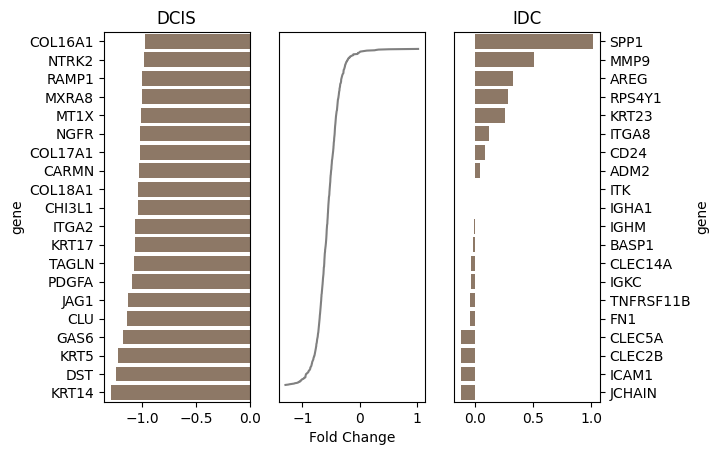

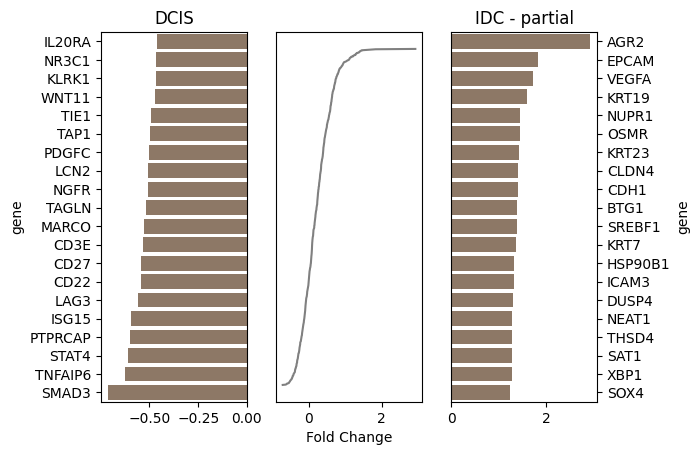

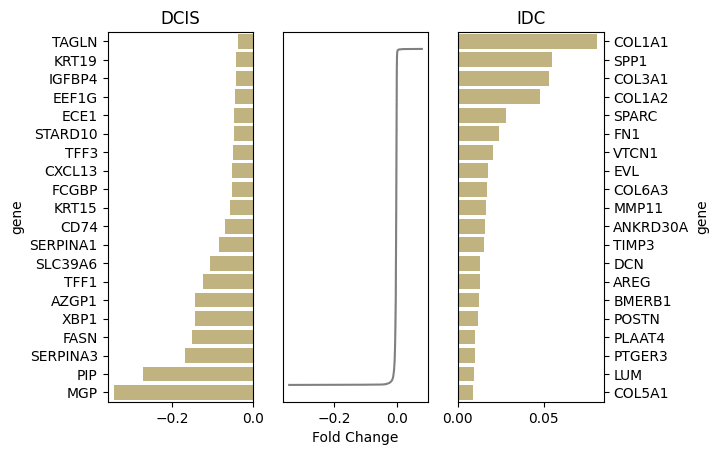

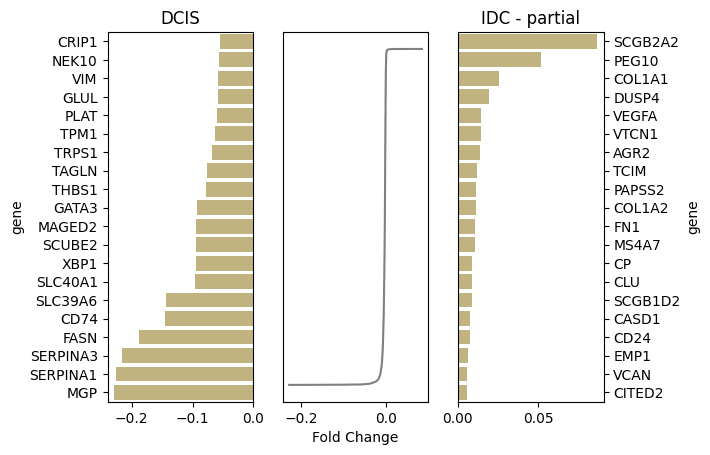

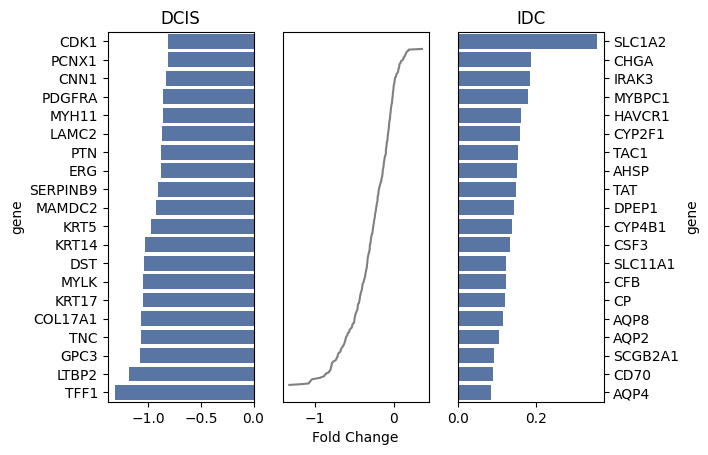

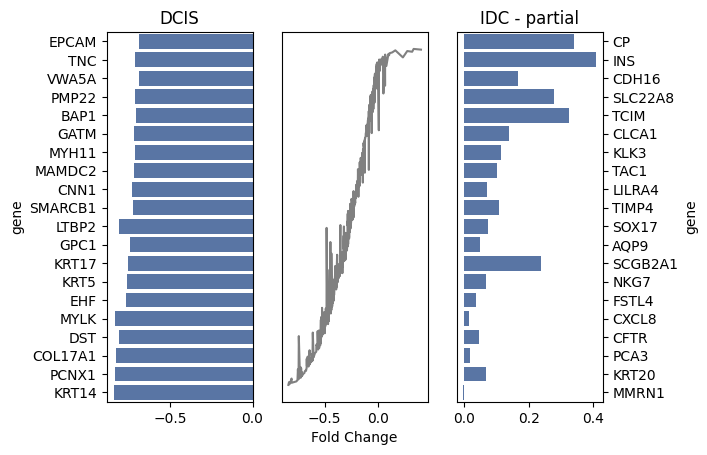

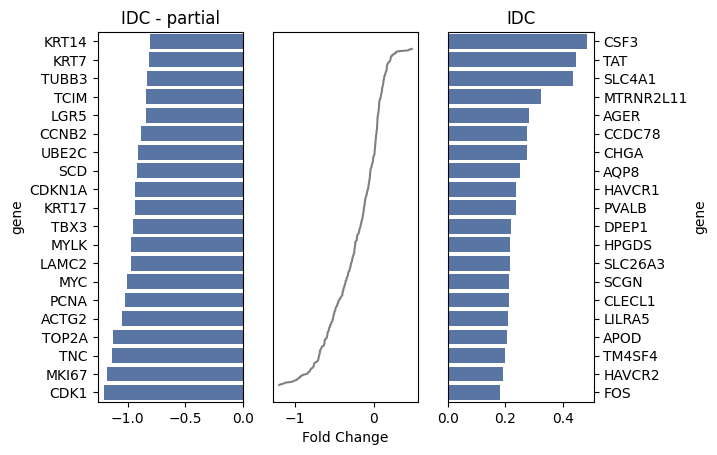

In [383]:
n = 20
for dti, annot in rank_source.index.to_list():
    color = dti_to_color[dti]
    fig, axs = plt.subplots(ncols=3)
    rank_series = rank_source.loc[(dti, annot)]
    keep = ~pd.isnull(rank_series)
    rank_series = rank_series[keep]
    idxs = np.argsort(rank_series.values)
    rank_series = rank_series[idxs]

    fc_series = fc_source.loc[(dti, annot)]
    fc_series = fc_series[keep]
    fc_series = fc_series[idxs]
    
    sns.lineplot(y=np.arange(len(rank_series)), x=fc_series.values, ax=axs[1], c='gray')
    axs[1].set_yticks([])
    axs[1].set_xlabel('Fold Change')

    neg = fc_series[:n][::-1]
    sns.barplot(y=neg.reset_index()['gene'], x=neg.values, ax=axs[0], color=color)
    axs[0].set_title(annot.split('|')[0])

    pos = fc_series[-n:][::-1]
    sns.barplot(y=pos.reset_index()['gene'], x=pos.values, ax=axs[2], color=color)
    axs[2].yaxis.set_label_position("right")
    axs[2].yaxis.tick_right()
    axs[2].set_title(annot.split('|')[1])

    name = f'fc_plots_{case}_{dti}_{annot}.svg'.replace('|', '-')
    plt.savefig(fig_dir / name)
    plt.show()

In [384]:
rank_df

value                                    \
gene                               A2M   A4GALT    AAAS    AACS    AADAT   
roi1|cosmx_0|DCIS|IDC              NaN      NaN     NaN     NaN      NaN   
roi1|vishd_0|DCIS|IDC             29.0  10209.0  2380.0  1569.0   9258.0   
roi1|xenium_0|DCIS|IDC - partial   NaN      NaN     NaN     NaN      NaN   
roi1|xenium_0|DCIS|IDC             NaN      NaN     NaN     NaN      NaN   
roi1|xenium_0|IDC - partial|IDC    NaN      NaN     NaN     NaN      NaN   
roi2|cosmx_0|DCIS|IDC - partial    NaN      NaN     NaN     NaN      NaN   
roi2|vishd_0|DCIS|IDC - partial   70.0   7872.0  2511.0  4592.0  10423.0   
roi2|xenium_0|DCIS|IDC - partial   NaN      NaN     NaN     NaN      NaN   

                                                                            \
gene                               AAGAB     AAK1   AAMDC    AAMP     AAR2   
roi1|cosmx_0|DCIS|IDC                NaN      NaN     NaN     NaN      NaN   
roi1|vishd_0|DCIS|IDC             4873.0  10934.0  6518.0  1897.0   4334.0   
roi1|xenium_0|DCIS|IDC - partial     NaN      NaN     NaN     NaN      NaN   
roi1|xenium_0|DCIS|IDC               NaN      NaN     NaN     NaN      NaN   
roi1|xenium_0|IDC - partial|IDC      NaN      NaN     NaN     NaN      NaN   
roi2|cosmx_0|DCIS|IDC - partial      NaN      NaN     NaN     NaN      NaN   
roi2|vishd_0|DCIS|IDC - partial   1862.0   4798.0  2548.0  1286.0  10366.0   
roi2|xenium_0|DCIS|IDC - partial     NaN      NaN     NaN     NaN      NaN   

                                  ...                                    \
gene                              ...    ZUP1    ZW10   ZWILCH    ZWINT   
roi1|cosmx_0|DCIS|IDC             ...     NaN     NaN      NaN      NaN   
roi1|vishd_0|DCIS|IDC             ...  6297.0  9025.0  10858.0   7472.0   
roi1|xenium_0|DCIS|IDC - partial  ...     NaN     NaN      NaN      NaN   
roi1|xenium_0|DCIS|IDC            ...     NaN     NaN      NaN      NaN   
roi1|xenium_0|IDC - partial|IDC   ...     NaN     NaN      NaN      NaN   
roi2|cosmx_0|DCIS|IDC - partial   ...     NaN     NaN      NaN      NaN   
roi2|vishd_0|DCIS|IDC - partial   ...  6844.0  5197.0   7643.0  11206.0   
roi2|xenium_0|DCIS|IDC - partial  ...     NaN     NaN      NaN      NaN   

                                                                          \
gene                                ZXDB    ZXDC  ZYG11A  ZYG11B     ZYX   
roi1|cosmx_0|DCIS|IDC                NaN     NaN     NaN     NaN     NaN   
roi1|vishd_0|DCIS|IDC             9164.0  7043.0  9534.0  4300.0  2863.0   
roi1|xenium_0|DCIS|IDC - partial     NaN     NaN     NaN     NaN     NaN   
roi1|xenium_0|DCIS|IDC               NaN     NaN     NaN     NaN     NaN   
roi1|xenium_0|IDC - partial|IDC      NaN     NaN     NaN     NaN     NaN   
roi2|cosmx_0|DCIS|IDC - partial      NaN     NaN     NaN     NaN     NaN   
roi2|vishd_0|DCIS|IDC - partial   5228.0  5909.0  5781.0  9661.0  1191.0   
roi2|xenium_0|DCIS|IDC - partial     NaN     NaN     NaN     NaN     NaN   

                                          
gene                               ZZEF1  
roi1|cosmx_0|DCIS|IDC                NaN  
roi1|vishd_0|DCIS|IDC             6934.0  
roi1|xenium_0|DCIS|IDC - partial     NaN  
roi1|xenium_0|DCIS|IDC               NaN  
roi1|xenium_0|IDC - partial|IDC      NaN  
roi2|cosmx_0|DCIS|IDC - partial      NaN  
roi2|vishd_0|DCIS|IDC - partial   1578.0  
roi2|xenium_0|DCIS|IDC - partial     NaN  

[8 rows x 12174 columns]

In [398]:
percentile_df = rank_df / rank_df.values.max(1, keepdims=True, where=~pd.isnull(rank_df.values), initial=0)
percentile_df

value                                \
gene                                   A2M    A4GALT      AAAS      AACS   
roi1|cosmx_0|DCIS|IDC                  NaN       NaN       NaN       NaN   
roi1|vishd_0|DCIS|IDC             0.002493  0.877514  0.204573  0.134863   
roi1|xenium_0|DCIS|IDC - partial       NaN       NaN       NaN       NaN   
roi1|xenium_0|DCIS|IDC                 NaN       NaN       NaN       NaN   
roi1|xenium_0|IDC - partial|IDC        NaN       NaN       NaN       NaN   
roi2|cosmx_0|DCIS|IDC - partial        NaN       NaN       NaN       NaN   
roi2|vishd_0|DCIS|IDC - partial   0.006143  0.690769  0.220340  0.402948   
roi2|xenium_0|DCIS|IDC - partial       NaN       NaN       NaN       NaN   

                                                                          \
gene                                 AADAT     AAGAB      AAK1     AAMDC   
roi1|cosmx_0|DCIS|IDC                  NaN       NaN       NaN       NaN   
roi1|vishd_0|DCIS|IDC             0.795771  0.418859  0.939832  0.560254   
roi1|xenium_0|DCIS|IDC - partial       NaN       NaN       NaN       NaN   
roi1|xenium_0|DCIS|IDC                 NaN       NaN       NaN       NaN   
roi1|xenium_0|IDC - partial|IDC        NaN       NaN       NaN       NaN   
roi2|cosmx_0|DCIS|IDC - partial        NaN       NaN       NaN       NaN   
roi2|vishd_0|DCIS|IDC - partial   0.914619  0.163391  0.421025  0.223587   
roi2|xenium_0|DCIS|IDC - partial       NaN       NaN       NaN       NaN   

                                                      ...                      \
gene                                  AAMP      AAR2  ...      ZUP1      ZW10   
roi1|cosmx_0|DCIS|IDC                  NaN       NaN  ...       NaN       NaN   
roi1|vishd_0|DCIS|IDC             0.163057  0.372529  ...  0.541258  0.775744   
roi1|xenium_0|DCIS|IDC - partial       NaN       NaN  ...       NaN       NaN   
roi1|xenium_0|DCIS|IDC                 NaN       NaN  ...       NaN       NaN   
roi1|xenium_0|IDC - partial|IDC        NaN       NaN  ...       NaN       NaN   
roi2|cosmx_0|DCIS|IDC - partial        NaN       NaN  ...       NaN       NaN   
roi2|vishd_0|DCIS|IDC - partial   0.112847  0.909617  ...  0.600562  0.456037   
roi2|xenium_0|DCIS|IDC - partial       NaN       NaN  ...       NaN       NaN   

                                                                          \
gene                                ZWILCH     ZWINT      ZXDB      ZXDC   
roi1|cosmx_0|DCIS|IDC                  NaN       NaN       NaN       NaN   
roi1|vishd_0|DCIS|IDC             0.933299  0.642255  0.787691  0.605381   
roi1|xenium_0|DCIS|IDC - partial       NaN       NaN       NaN       NaN   
roi1|xenium_0|DCIS|IDC                 NaN       NaN       NaN       NaN   
roi1|xenium_0|IDC - partial|IDC        NaN       NaN       NaN       NaN   
roi2|cosmx_0|DCIS|IDC - partial        NaN       NaN       NaN       NaN   
roi2|vishd_0|DCIS|IDC - partial   0.670674  0.983327  0.458757  0.518515   
roi2|xenium_0|DCIS|IDC - partial       NaN       NaN       NaN       NaN   

                                                                          
gene                                ZYG11A    ZYG11B       ZYX     ZZEF1  
roi1|cosmx_0|DCIS|IDC                  NaN       NaN       NaN       NaN  
roi1|vishd_0|DCIS|IDC             0.819495  0.369606  0.246089  0.596012  
roi1|xenium_0|DCIS|IDC - partial       NaN       NaN       NaN       NaN  
roi1|xenium_0|DCIS|IDC                 NaN       NaN       NaN       NaN  
roi1|xenium_0|IDC - partial|IDC        NaN       NaN       NaN       NaN  
roi2|cosmx_0|DCIS|IDC - partial        NaN       NaN       NaN       NaN  
roi2|vishd_0|DCIS|IDC - partial   0.507283  0.847754  0.104510  0.138470  
roi2|xenium_0|DCIS|IDC - partial       NaN       NaN       NaN       NaN  

[8 rows x 12174 columns]

In [403]:
counts = rank_df.copy()
counts['roi'] = [x.split('|')[0] for x in counts.index.to_list()]
counts['annot'] = [re.sub(r'^.*\|.*\|(.*\|.*)$', r'\1', x) for x in counts.index.to_list()]
counts = counts.groupby(['roi', 'annot']).count()
counts

# dtype_counts = np.count_nonzero(~pd.isnull(percentile_df), axis=0)
# counts.max()

value                                               \
gene                      A2M A4GALT AAAS AACS AADAT AAGAB AAK1 AAMDC AAMP   
roi  annot                                                                   
roi1 DCIS|IDC               1      1    1    1     1     1    1     1    1   
     DCIS|IDC - partial     0      0    0    0     0     0    0     0    0   
     IDC - partial|IDC      0      0    0    0     0     0    0     0    0   
roi2 DCIS|IDC - partial     1      1    1    1     1     1    1     1    1   

                              ...                                          \
gene                    AAR2  ... ZUP1 ZW10 ZWILCH ZWINT ZXDB ZXDC ZYG11A   
roi  annot                    ...                                           
roi1 DCIS|IDC              1  ...    1    1      1     1    1    1      1   
     DCIS|IDC - partial    0  ...    0    0      0     0    0    0      0   
     IDC - partial|IDC     0  ...    0    0      0     0    0    0      0   
roi2 DCIS|IDC - partial    1  ...    1    1      1     1    1    1      1   

                                          
gene                    ZYG11B ZYX ZZEF1  
roi  annot                                
roi1 DCIS|IDC                1   1     1  
     DCIS|IDC - partial      0   0     0  
     IDC - partial|IDC       0   0     0  
roi2 DCIS|IDC - partial      1   1     1  

[4 rows x 12174 columns]

In [404]:
counts.max(1)

roi   annot             
roi1  DCIS|IDC              3
      DCIS|IDC - partial    1
      IDC - partial|IDC     1
roi2  DCIS|IDC - partial    3
dtype: int64

In [178]:
f.mean(0)

              gene   
value_scaled  A1CF      -0.208485
              A2M       -0.525652
              A2ML1     -0.331405
              A3GALT2    0.251325
              A4GALT    -0.272731
                           ...   
              ZXDC      -0.394204
              ZYG11A    -0.389363
              ZYG11B    -0.445304
              ZYX       -0.325708
              ZZEF1     -0.355542
Length: 18166, dtype: float64

In [179]:
f

value_scaled                                \
gene                               A1CF       A2M     A2ML1   A3GALT2   
vishd_0|Normal|DCIS                 NaN       NaN       NaN       NaN   
vishd_0|DCIS|IDC - partial     -0.41697 -0.800933 -0.662809 -0.497351   
vishd_0|IDC - partial|IDC       0.00000 -0.250371  0.000000  1.000000   

                                                                         \
gene                          A4GALT A4GNT      AAAS      AACS    AADAC   
vishd_0|Normal|DCIS              NaN   NaN       NaN       NaN      NaN   
vishd_0|DCIS|IDC - partial -0.592252  -0.4 -0.373964 -0.310572 -0.54778   
vishd_0|IDC - partial|IDC   0.046790   0.0 -0.116390 -0.154031  0.00000   

                                    ...                                \
gene                       AADACL2  ...      ZW10    ZWILCH     ZWINT   
vishd_0|Normal|DCIS            NaN  ...       NaN       NaN       NaN   
vishd_0|DCIS|IDC - partial    -0.4  ... -0.407650 -0.320965 -0.077039   
vishd_0|IDC - partial|IDC      0.0  ...  0.099096  0.252414  0.041266   

                                                                              \
gene                            ZXDA      ZXDB      ZXDC    ZYG11A    ZYG11B   
vishd_0|Normal|DCIS              NaN       NaN       NaN       NaN       NaN   
vishd_0|DCIS|IDC - partial -0.654500 -0.551334 -0.316591 -0.196160 -0.427335   
vishd_0|IDC - partial|IDC   0.882024  0.146333 -0.471816 -0.582566 -0.463273   

                                                
gene                             ZYX     ZZEF1  
vishd_0|Normal|DCIS              NaN       NaN  
vishd_0|DCIS|IDC - partial -0.239532 -0.380783  
vishd_0|IDC - partial|IDC  -0.411884 -0.330301  

[3 rows x 18166 columns]

In [175]:
series

              gene       
value_scaled  CACNA1C       -0.957674
              RNF183        -0.955604
              FBXO48        -0.938052
              ZSCAN12       -0.937659
              SAP25         -0.935340
                               ...   
              HSPA1A/B            NaN
              MIR4435-2HG         NaN
              FCGR3A/B            NaN
              SAA1                NaN
              FCN1                NaN
Name: vishd_0|DCIS|IDC - partial, Length: 18166, dtype: float64

<Axes: ylabel='vishd_0|DCIS|IDC - partial'>

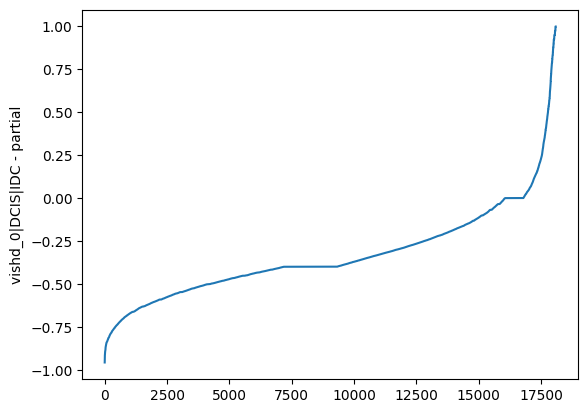

In [176]:
sns.lineplot(x=np.arange(len(series)), y=series)

In [168]:
np.log2(.2)

-2.321928094887362

In [149]:
np.mean([1, np.nan, 2], where=[True, False, True])

1.5

<Axes: xlabel='annotation', ylabel='value_scaled'>

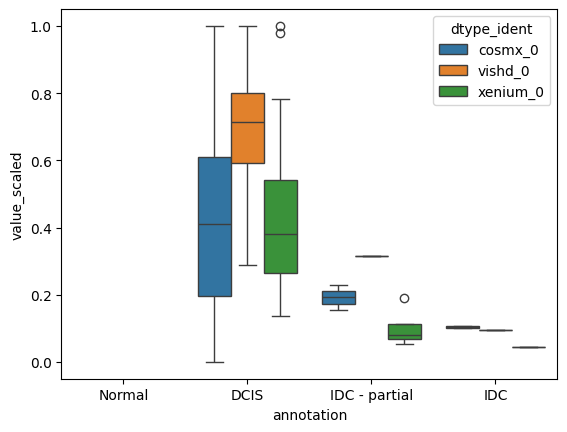

In [109]:
gene = 'KRT5'
dti = 'xenium_0'
f = df[df['gene'] == gene]
sns.boxplot(data=f, x='annotation', y='value_scaled', hue='dtype_ident', order=pathology_order, hue_order=dti_order)

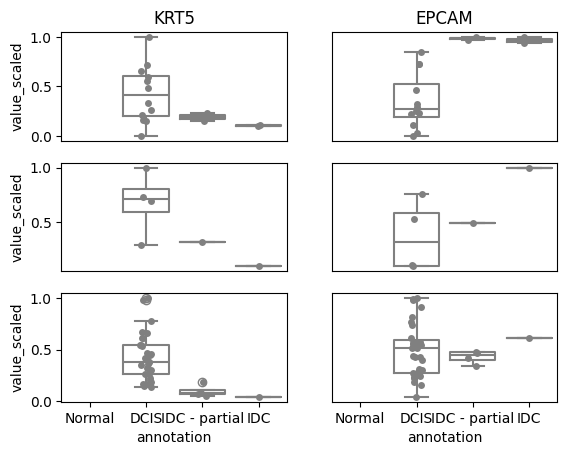

In [130]:
genes = ['KRT5', 'EPCAM']

fig, axs = plt.subplots(nrows=len(dti_order), ncols=len(genes))
for r, dti in enumerate(dti_order):
    for c, gene in enumerate(genes):
        ax = axs[r, c]
        f = df[df['gene'] == gene]
        if dti in f['dtype_ident'].to_list():
            source = f[f['dtype_ident']==dti]
            sns.boxplot(data=source, x='annotation', y='value_scaled', order=pathology_order, fill=None, color='gray', ax=ax)
            sns.stripplot(data=source, x='annotation', y='value_scaled', order=pathology_order, color='gray', dodge=True, ax=ax)

        if r < axs.shape[0] - 1:
            ax.set_xticks([])
            ax.set_xlabel(None)
        if r == 0:
            ax.set_title(gene)
        if c != 0:
            ax.set_yticks([])
            ax.set_ylabel(None)
            


In [103]:
f = df[df['gene'] == gene]
f

,roi,dtype_ident,region_id,annotation,gene,value,value_scaled
1800,roi1,cosmx_0,25f59172-9dc6-4340-a21f-2a2b557176cf,DCIS,KRT5,2.035534,0.593313
1801,roi1,cosmx_0,a4719551-76dd-4117-a82a-c086568f52f2,IDC,KRT5,0.344623,0.100450
1802,roi1,cosmx_0,7ee62508-a502-404f-b93c-47d0fa181aab,IDC,KRT5,0.371489,0.108281
24774,roi1,vishd_0,efac94bc-f48c-410e-a57d-3cfccc9f95f5,DCIS,KRT5,0.015104,0.734087
24775,roi1,vishd_0,a8828943-5520-4944-a509-4138d186b364,IDC,KRT5,0.001975,0.096001
40766,roi1,xenium_0,b28d28d2-098a-41aa-8a99-24f8c8753897,DCIS,KRT5,1.334269,0.380852
40767,roi1,xenium_0,20e99f45-3070-4653-8b26-9f9ea56631cb,DCIS,KRT5,1.031089,0.294313
40768,roi1,xenium_0,d2fff7b6-cee3-404e-abc3-e1b7d7e0a6c6,DCIS,KRT5,0.922689,0.263371
40769,roi1,xenium_0,3dcff188-4448-4511-9576-f5d6397b5c5f,DCIS,KRT5,1.141935,0.325952
40770,roi1,xenium_0,606319be-6df3-4fb7-85f4-0c62f2738122,IDC - partial,KRT5,0.664997,0.189816


<Axes: xlabel='None-dtype_ident', ylabel='annotation'>

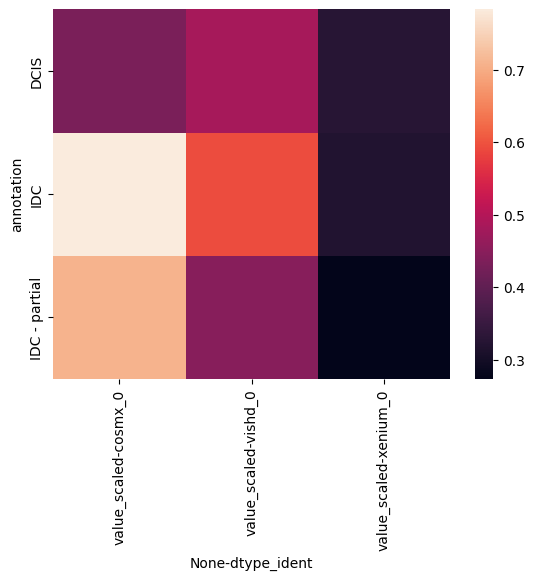

In [107]:
gs = ['dtype_ident', 'annotation']
grouped = df[gs + ['value_scaled']].groupby(gs).mean().reset_index()
source = grouped.pivot(columns='dtype_ident', index='annotation')
sns.heatmap(source)


In [101]:
gene = 'KRT5'
# roi_order = sorted(set(df['roi']))
dti_order = sorted(set(df['dtype_ident']))

col_order = [f'{annot}|{dti}' for annot in pathology_order for dti in dti_order]

# fig, axs = plt.subplots(nrows=len(roi_order), ncols=len(col_order))
new_data = []
for c, x in enumerate(col_order):
    # ax = axs[r, c]
    annot, dti = x.split('|')
    # print(roi, dti, annot)

    m = df['annotation'] == annot
    m &= df['dtype_ident'] == dti
    m &= df['roi'] == roi
    m &= df['gene'] == gene
    f = df[m]
    val = f['value'].mean()
    row.append(val)
new_data.append(row)
source = pd.DataFrame(data=new_data, columns=col_order, index=roi_order)
source
        
    

,Normal|cosmx_0,Normal|vishd_0,Normal|xenium_0,DCIS|cosmx_0,DCIS|vishd_0,DCIS|xenium_0,IDC - partial|cosmx_0,IDC - partial|vishd_0,IDC - partial|xenium_0,IDC|cosmx_0,IDC|vishd_0,IDC|xenium_0
roi1,NaN,NaN,NaN,2.035534,0.015104,1.107496,NaN,NaN,0.664997,0.358056,0.001975,0.155815
roi2,NaN,NaN,NaN,0.446476,0.014294,0.851805,0.658579,0.00647,0.249736,NaN,NaN,NaN
roi3,NaN,NaN,NaN,1.625347,0.013241,1.650720,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

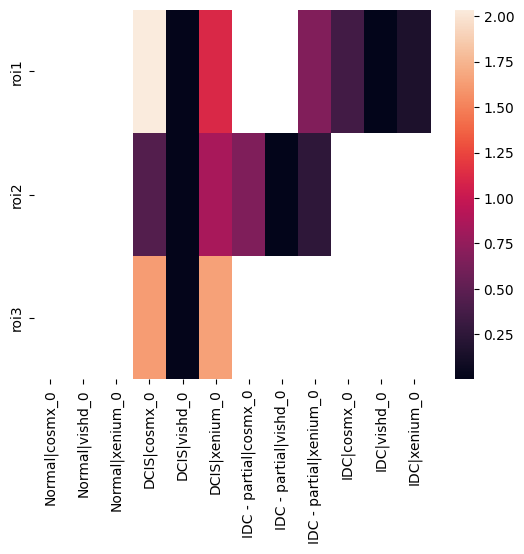

In [102]:
sns.heatmap(data=source)

In [94]:
f.pivot(columns=['gene']

['Normal|cosmx_0',
 'Normal|vishd_0',
 'Normal|xenium_0',
 'DCIS|cosmx_0',
 'DCIS|vishd_0',
 'DCIS|xenium_0',
 'IDC - partial|cosmx_0',
 'IDC - partial|vishd_0',
 'IDC - partial|xenium_0',
 'IDC|cosmx_0',
 'IDC|vishd_0',
 'IDC|xenium_0']

In [62]:
data = next(iter(roi_to_data.values()))

In [63]:
df = data['results']['xenium_0']['expression']
df

,ABCC11,ACE2,ACKR1,ACTA2,ACTG2,ADAM28,ADAM8,ADAMTS1,ADGRE1,ADGRL4,...,UCHL1,UMOD,UPK3B,VCAN,VEGFA,VSIG4,VWA5A,VWF,region_id,id
region_id,,,,,,,,,,,,,,,,,,,,,
b28d28d2-098a-41aa-8a99-24f8c8753897,2.367336,0.247504,0.111582,0.954909,2.156593,1.142259,0.437495,0.183054,0.780721,0.068724,...,0.054523,0.000000,0.115300,0.406304,1.026676,0.484440,1.517908,0.074541,b28d28d2-098a-41aa-8a99-24f8c8753897,b28d28d2-098a-41aa-8a99-24f8c8753897
20e99f45-3070-4653-8b26-9f9ea56631cb,0.760771,0.117603,0.000000,0.907453,1.621899,0.519922,0.221510,0.502068,0.210022,0.065410,...,0.071773,0.269802,0.176012,0.425762,1.136258,0.275183,0.933711,0.066819,20e99f45-3070-4653-8b26-9f9ea56631cb,20e99f45-3070-4653-8b26-9f9ea56631cb
d2fff7b6-cee3-404e-abc3-e1b7d7e0a6c6,1.085994,0.150628,0.039450,0.867556,1.677064,0.570871,0.465673,0.152543,0.181714,0.085618,...,0.041811,0.000000,0.341136,0.308215,1.106848,0.089671,0.862171,0.062913,d2fff7b6-cee3-404e-abc3-e1b7d7e0a6c6,d2fff7b6-cee3-404e-abc3-e1b7d7e0a6c6
3dcff188-4448-4511-9576-f5d6397b5c5f,0.356522,0.000000,0.000000,1.540391,2.781667,0.463744,0.222751,0.188129,0.288146,0.034933,...,0.092014,0.000000,0.000000,1.207385,0.537809,0.118573,0.582554,0.000000,3dcff188-4448-4511-9576-f5d6397b5c5f,3dcff188-4448-4511-9576-f5d6397b5c5f
606319be-6df3-4fb7-85f4-0c62f2738122,0.614701,0.000000,0.000000,1.049450,3.095929,0.286561,0.428746,0.576896,0.000000,0.212355,...,0.448851,0.000000,0.000000,0.684915,1.652138,0.187397,0.592882,0.185815,606319be-6df3-4fb7-85f4-0c62f2738122,606319be-6df3-4fb7-85f4-0c62f2738122
25defdcc-c8c1-4511-9ace-d9dbf639f2b6,0.639114,0.048059,0.024979,0.563703,1.885116,0.513062,0.418641,0.161223,0.028926,0.027327,...,0.191659,0.000000,0.166925,0.734555,1.526690,0.241376,1.010853,0.023616,25defdcc-c8c1-4511-9ace-d9dbf639f2b6,25defdcc-c8c1-4511-9ace-d9dbf639f2b6


In [64]:
df['region_id'] = df.index.to_list()
melted = df.melt(id_vars='region_id')
melted


,region_id,variable,value
0,b28d28d2-098a-41aa-8a99-24f8c8753897,ABCC11,2.367336
1,20e99f45-3070-4653-8b26-9f9ea56631cb,ABCC11,0.760771
2,d2fff7b6-cee3-404e-abc3-e1b7d7e0a6c6,ABCC11,1.085994
3,3dcff188-4448-4511-9576-f5d6397b5c5f,ABCC11,0.356522
4,606319be-6df3-4fb7-85f4-0c62f2738122,ABCC11,0.614701
...,...,...,...
2857,20e99f45-3070-4653-8b26-9f9ea56631cb,id,20e99f45-3070-4653-8b26-9f9ea56631cb
2858,d2fff7b6-cee3-404e-abc3-e1b7d7e0a6c6,id,d2fff7b6-cee3-404e-abc3-e1b7d7e0a6c6
2859,3dcff188-4448-4511-9576-f5d6397b5c5f,id,3dcff188-4448-4511-9576-f5d6397b5c5f
2860,606319be-6df3-4fb7-85f4-0c62f2738122,id,606319be-6df3-4fb7-85f4-0c62f2738122


In [ ]:
melted.groupby('variable

In [33]:
d = json.load(open('/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/imaris/rois/regions/roi3_metadata.json'))
d.keys()

dict_keys(['case_to_pathology_annotations', 'case_to_pathology_colors', 'pathology_order', 'region_id_to_pathology', 'region_ids', 'dtypes', 'sids'])

In [34]:
d['case_to_pathology_annotations']

{'HT704B1': {'roi1': {'b28d28d2-098a-41aa-8a99-24f8c8753897': 'DCIS',
   '8f7fd7f0-ca13-43d5-a8a5-bc46e8f9b687': 'IDC - partial',
   'a4719551-76dd-4117-a82a-c086568f52f2': 'IDC'},
  'roi2': {'c2df8514-9463-481a-9b68-c81dd634bb9a': 'DCIS',
   '244c386c-93ac-4a5f-bf52-43dcce7a1388': 'IDC - partial'},
  'roi3': {'d9293330-df8b-43f9-8b88-2375643b60aa': 'DCIS'}},
 'HT891Z1': {'roi1': {'18073a83-5d22-4c2a-8cc8-e1b27a4de88e': 'Normal',
   'f478fe10-a739-49b6-a66b-e78a89114bb8': 'HG PIN',
   '5360344d-4cc6-495c-88c8-920d753afa68': 'GP3'},
  'roi2': {'4fd912e9-9eda-4290-aab8-8cfb9bfedb43': 'Normal',
   '7a3535f1-c30c-40c1-9d31-24c2ee7e58f9': 'HG PIN',
   '9ddde78f-2e7b-4259-9bf9-efdd0a005b79': 'GP3'},
  'roi2-p2': {'406ac3bf-8609-4786-a1df-6540b4970cea': 'GP3',
   'fc0a0ccf-7386-416f-b163-99041f2d8918': 'HG PIN',
   '9ddde78f-2e7b-4259-9bf9-efdd0a005b79': 'GP3'}}}

In [35]:
d['case_to_pathology_colors']

{'HT704B1': {'IDC': [150, 29, 138],
  'IDC - partial': [171, 20, 12],
  'DCIS': [191, 128, 11],
  'Normal': [36, 117, 15]},
 'HT891Z1': {'GP3': [150, 29, 138],
  'HG PIN': [191, 128, 11],
  'Normal': [36, 117, 15]}}

In [36]:
d['pathology_order']

['Normal', 'DCIS', 'IDC - partial', 'IDC']

In [37]:
d['region_id_to_pathology']

{'d9293330-df8b-43f9-8b88-2375643b60aa': 'DCIS',
 '5cb05ed3-2b22-4fd7-bedf-dc8a789df2c0': 'DCIS',
 '7a787adf-8fba-403e-9f14-6e1031dcc49a': 'DCIS',
 '15f75816-6cc4-4003-a1dd-1cb39ba6d792': 'DCIS',
 'f3f5a129-0688-4a27-8b9f-417d87319d31': 'DCIS',
 'feb5fb14-b1db-4fa6-b190-74d5c2e9b509': 'DCIS',
 'a991b564-c33e-4556-b5d7-06ecb611ef4f': 'DCIS',
 'e3f4c83f-8e8d-481b-9749-fad97ad55673': 'DCIS',
 '71dff1df-d5bb-40c3-a241-659e82e8a43e': 'DCIS',
 '8df68aa8-18a4-47a0-9d8b-796d590eadf9': 'DCIS',
 'cb24a200-ca1b-4f9c-bec1-04485e7f2a17': 'DCIS',
 '9c138875-2b24-4fb4-a836-9c31a86aaa1a': 'DCIS',
 '1cf88277-3817-401b-96f9-ff436c17b4e3': 'DCIS',
 'b5b50caf-310a-46a9-8625-0117a4cc23ef': 'DCIS',
 'd19aa3c9-50d7-472f-b89d-4b0020f6e2c9': 'DCIS',
 '087dda61-66fa-411c-a0a5-9527a7e91bb7': 'DCIS',
 '88d99522-c143-4f13-966a-bfb325d36211': 'DCIS',
 '175d7942-999a-4970-81f6-b8628d77bf14': 'DCIS',
 '00e77665-e65f-43b8-9384-64e0bc8c2efa': 'DCIS',
 'ec2baaa5-3c15-48f3-8fdb-d59297f5b1d8': 'DCIS',
 'a09d553a-cfd4-4208